In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

#from IPython.display import display, Latex, clear_output

# Program bar
from tqdm.notebook import trange, tqdm

# jedi 0.14.1 autocomlete fails; will be fixed in 0.14.2
%config Completer.use_jedi = False

In [2]:
import pynrc
from pynrc import nrc_utils, robust

In [39]:
from pynrc.detops import create_detops
from pynrc.reduce.ref_pixels import reffix_hxrg
from pynrc.nrc_utils import jl_poly_fit, jl_poly, hist_indices
from pynrc.reduce.calib import get_ipc_kernel, ipc_deconvolve, ppc_deconvolve
from pynrc.simul.ngNRC import gen_col_noise, add_col_noise, gen_ramp_biases

from pynrc.reduce.calib import get_fits_data, gen_super_bias, gen_super_dark
from pynrc.reduce.calib import chisqr_red, ramp_derivative, gen_col_variations
from pynrc.reduce.calib import gen_ref_dict#, get_bias_offsets, get_oddeven_offsets, get_ref_instability

In [4]:
import os, gzip, json
from copy import deepcopy
from astropy.io import fits
from scipy import ndimage

In [5]:
# basedir = '/Volumes/NIRData/NIRCam/Char_Darks/CV3/FITS/'
basedir = '/Users/jarron/NIRCam/Data/CV3_Darks/'

scaid = 485
indir = os.path.join(basedir, str(scaid)) + '/'

# Get file names within directory
allfits = [file for file in os.listdir(indir) if file.endswith('.fits')]
allfits = np.sort(allfits)

nfiles = len(allfits)

In [6]:
# Get header information and create a NIRCam detector timing instance
hdr = fits.getheader(indir+allfits[0])
det = create_detops(hdr)

nchan = det.nout
nx = det.xpix
ny = det.ypix
nz = det.multiaccum.ngroup
chsize = det.chsize

# Time array
tarr = np.arange(1, nz+1) * det.time_group

[     pynrc:INFO] Initializing SCA 485/A5


In [7]:
outdir = '/Users/jarron/NIRCam/dark_analysis/CV3/'
# outdir = os.path.join(outdir, str(scaid)) + '/'

# Initial Super Bias Image

In [8]:
outname = f'{outdir}SUPER_BIAS/SUPER_BIAS_INIT_{scaid}.FITS'
file_exists = os.path.isfile(outname)

In [9]:
kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}

all_files = [indir + f for f in allfits]

if file_exists:
    super_bias, _super_bias = get_fits_data(outname)
else:
    super_bias, _super_bias = gen_super_bias(all_files, deg=1, nsplit=2, return_std=True, **kwargs)
    # Save superbias frame to directory
    hdu = fits.PrimaryHDU(np.array([super_bias, _super_bias]))
    hdu.writeto(outname, overwrite=True)

# Super Dark Ramp

In [10]:
# Create or read super dark ramp
kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}

outname = f'{outdir}SUPER_DARK/SUPER_DARK_RAMP_{scaid}.FITS'
file_exists = os.path.isfile(outname)

if file_exists:
    super_dark_ramp = get_fits_data(outname)
    
    # Grab Super Bias
    outname = f'{outdir}SUPER_BIAS/SUPER_BIAS_{scaid}.FITS'
    super_bias = get_fits_data(outname)
    
    # Generate pixel masks dictionary
    outname = f'{outdir}SUPER_DARK/PIXEL_MASKS_{scaid}.FITS.gz'
    masks_dict = {}
    hdul = fits.open(outname)
    for hdu in hdul:
        key = hdu.name.lower()
        masks_dict[key] = hdu.data.astype('bool')
    hdul.close()
else:
    res = gen_super_dark(all_files, super_bias=super_bias, **kwargs)
    super_dark_ramp, bias_off, masks_dict = res

    # Add residual bias offset
    super_bias += bias_off
    
    # Save updated superbias frame to directory
    outname = f'{outdir}SUPER_BIAS/SUPER_BIAS_{scaid}.FITS'
    hdu = fits.PrimaryHDU(super_bias)
    hdu.writeto(outname, overwrite=True)
    
    # Save super dark ramp
    outname = f'{outdir}SUPER_DARK/SUPER_DARK_RAMP_{scaid}.FITS'
    hdu = fits.PrimaryHDU(super_dark_ramp.astype(np.float32))
    hdu.writeto(outname, overwrite=True)
    
    # Save mask dictionary to a compressed FITS file
    outname = f'{outdir}SUPER_DARK/PIXEL_MASKS_{scaid}.FITS.gz'
    hdul = fits.HDUList()

    for k in masks_dict.keys():
        data = masks_dict[k].astype('uint8')
        hdu = fits.ImageHDU(data, name=k)
        hdul.append(hdu)

    output = gzip.open(outname, 'wb')
    hdul.writeto(output, overwrite=True) 
    output.close()

# Column Variations

In [11]:
# Create a series of column offset models 
# These are likely FETS in the ASIC preamp or ADC 
# causing entire columns within a ramp to jump around
kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}

outname = f'{outdir}SUPER_DARK/SUPER_DARK_COLVAR_{scaid}.FITS'
file_exists = os.path.isfile(outname)

if file_exists:
    ramp_column_varations, header = get_fits_data(outname, return_header=True)
    prob_bad = header['PROB_VAR']
else:
    # Generate a compilation of column variations
    res = gen_col_variations(all_files, super_bias=super_bias, 
                             super_dark_ramp=super_dark_ramp, **kwargs)
    ramp_column_varations, prob_bad = res
    
    # Save column ramp variations
    hdu = fits.PrimaryHDU(ramp_column_varations)
    hdu.header['PROB_VAR'] = prob_bad
    hdu.writeto(outname, overwrite=True)

## Ref Pixels

In [12]:
kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}

outname = f'{outdir}SUPER_BIAS/BIAS_BEHAVIOR_{scaid}.JSON'
file_exists = os.path.isfile(outname)

if file_exists:
    # Load from JSON file
    with open(outname, 'r') as fp:
        ref_dict = json.load(fp)

    # Convert lists to np.array
    for k in ref_dict.keys():
        if isinstance(ref_dict[k], (list)):
            ref_dict[k] = np.array(ref_dict[k])
else:
    ref_dict = gen_ref_dict(all_files, super_bias, verbose=True, **kwargs)
    
    # Save to JSON file
    # Make a deepcopy of dict to convert np.array to lists
    dtemp = deepcopy(ref_dict)
    for k in dtemp.keys():
        if isinstance(dtemp[k], (np.ndarray)):
            dtemp[k] = dtemp[k].tolist()

    with open(outname, 'w') as fp:
        json.dump(dtemp, fp, sort_keys=False, indent=4)

In [13]:
# Create synthetic data
data = gen_ramp_biases(ref_dict, data_shape=(nz,ny,nx))
data += super_bias
data += super_dark_ramp

col_noise = gen_col_noise(ramp_column_varations, prob_bad)
data += col_noise


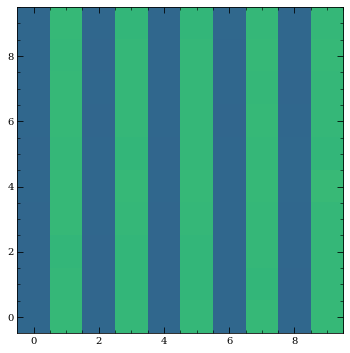

In [16]:
im = data[0] - super_bias

im = im[0:100,0:10]
mn = im.mean()
std = im.std()
plt.imshow(im, vmin=mn-3*std, vmax=mn+3*std)

# Super Dark Slope

In [17]:
cf = jl_poly_fit(tarr, super_dark_ramp)
super_dark = cf[1]

In [21]:
ramp_avg = np.median(super_dark_ramp.reshape([nz,-1]), axis=1)

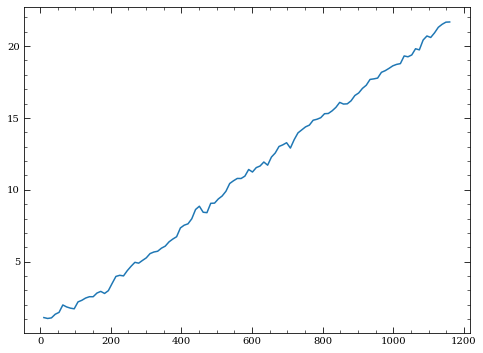

In [22]:
plt.plot(tarr, ramp_avg)

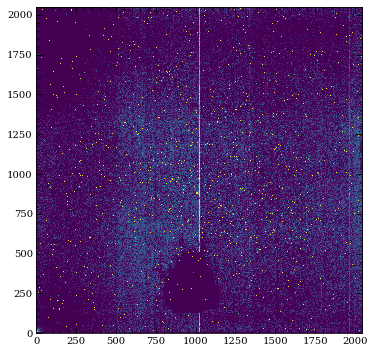

In [20]:
im = super_dark
mn = np.mean(im)
std = robust.std(im)

plt.imshow(super_dark, vmin=mn-3*std, vmax=mn+3*std)

1166.0975629211953 0.018714162596763347 0.01899901731318035


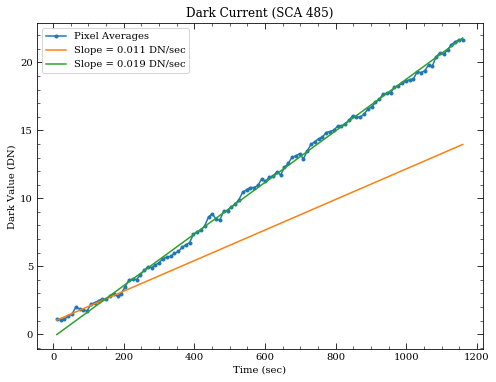

In [23]:

# print(np.median(super_bias0), np.median(super_dark2))

# Check linearity over flux range
plt.plot(tarr, ramp_avg, marker='.', label='Pixel Averages')

ind = tarr<200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

ind = tarr>200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))


plt.xlabel('Time (sec)')
plt.ylabel('Dark Value (DN)')
plt.title('Dark Current (SCA {})'.format(scaid))
plt.legend()
# plt.plot(tarr, ramp_avg2, marker='.', ls='none', color='C1')
# bias, slope2 = jl_poly_fit(tarr, ramp_avg2)
# plt.plot(tarr, tarr*slope2, color='C1')

print(np.median(super_bias), np.median(super_dark), cf[1])

1166.4249533983634 0.01872237275437635 0.019006404623438004


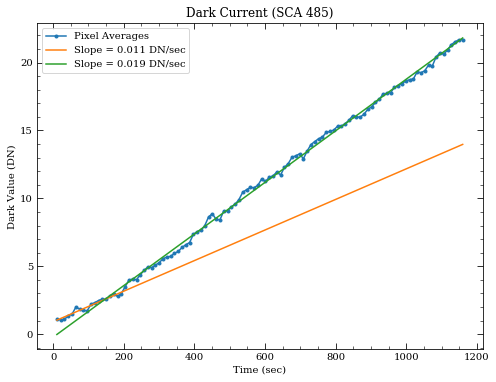

In [82]:

# print(np.median(super_bias0), np.median(super_dark2))

# Check linearity over flux range
plt.plot(tarr, ramp_avg, marker='.', label='Pixel Averages')

ind = tarr<200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

ind = tarr>200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))


plt.xlabel('Time (sec)')
plt.ylabel('Dark Value (DN)')
plt.title('Dark Current (SCA {})'.format(scaid))
plt.legend()
# plt.plot(tarr, ramp_avg2, marker='.', ls='none', color='C1')
# bias, slope2 = jl_poly_fit(tarr, ramp_avg2)
# plt.plot(tarr, tarr*slope2, color='C1')

print(np.median(super_bias), np.median(super_dark), cf[1])

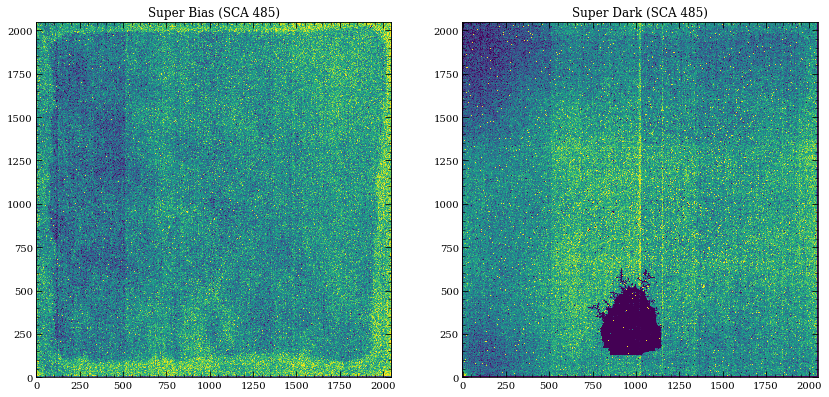

In [24]:
fig, axes = plt.subplots(1,2,figsize=(14,8))

titles = ['Super Bias (SCA {})'.format(scaid), 'Super Dark (SCA {})'.format(scaid)]
for i, im in enumerate([super_bias, super_dark]):

    mn = np.median(im)
    std = robust.medabsdev(im)

    vmin = mn - 3*std
    vmax = mn + 3*std
    ax = axes[i]
    ax.imshow(im, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

In [40]:
# Histogram of Dark Slope
im = super_dark
#im = dark_all[0]
binsize = 0.0001
bins = np.arange(im.min(), im.max() + binsize, binsize)
ig, vg, cv = hist_indices(im, bins=bins, return_more=True)

# Choose only those pixels at the peak binsize
nvals = np.array([len(i) for i in ig])
ind_nvals_max = np.where(nvals==nvals.max())[0][0]
ig_good = ig[ind_nvals_max]

Dark Current = 0.0188 DN/sec


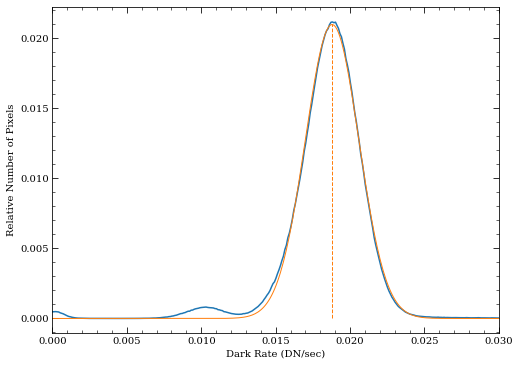

In [37]:
bg_max_dn = cv[ind_nvals_max]
#bg_max_e = bg_max_dn * gain
bg_max_npix = nvals[ind_nvals_max]

from astropy.modeling import models, fitting
mn_init, std_init = np.median(im), robust.std(im)
g_init = models.Gaussian1D(amplitude=nvals.max(), mean=mn_init, stddev=std_init)

fit_g = fitting.LevMarLSQFitter()
nvals_norm = nvals / nvals.sum()
ind_fit = (cv>mn_init-3*std_init) & (cv<mn_init+3*std_init)
g_res = fit_g(g_init, cv[ind_fit], nvals_norm[ind_fit])


bg_max_dn = g_res.mean.value
bg_max_npix = g_res.amplitude.value

plt.plot(cv, nvals_norm)
plt.plot(2*[bg_max_dn], [0,bg_max_npix], ls='--', lw=1, color='C1')
plt.plot(cv, g_res(cv), label='Gaussian', lw=1, color='C1')
plt.xlabel('Dark Rate (DN/sec)')
plt.ylabel('Relative Number of Pixels')

plt.xlim([0,0.03])

print('Dark Current = {:.4f} DN/sec'.format(bg_max_dn))

## Measurements

 1. Even/Odd column offsets (fixed)
 1. Reference drift over time
 1. Preamp reset noise
 1. 1/f Noise
     1. Pixel-based
     1. Spatially correlated across channels
     1. Spatially uncorrelated per channel
 1. kTC Noise
     1. Active
     1. Reference (ratio of two?)
 1. Read noise
     1. Active
     1. Active/Ref ratio
 1. IPC


In [144]:
data -= super_dark_ramp

[     pynrc:INFO] Initializing SCA 485/A5


In [24]:
from pynrc.reduce.ref_pixels import channel_smooth_savgol
from pynrc.maths.image_manip import binned_statistic, hist_indices

In [70]:
nfmax = 5

x = tmap[:nfmax,4:-4,4:chsize-4].ravel()

nbins = 512
binsize = (x.max() - x.min()) / nbins
bins = np.arange(x.min(), x.max() + binsize, binsize)

# Center values
cv = bins[:-1] + binsize

ch_avg = []
for ch in range(nchan):
    print(ch)
    y = data[:nfmax,4:-4,ch*chsize+4:(ch+1)*chsize-4]
    
    # Reverse x-direction if odd channel
    if (ch % 2) == 1:
        y = y[:,:,::-1]
        
    y = y.ravel()

    ybin = binned_statistic(x, y, func=np.median, bins=bins)
    ch_avg.append(ybin)

ch_avg = np.array(ch_avg)

0
1
2
3


In [129]:
x = tmap[:nfmax,0:4,0:chsize]
bins = x[:nfmax,:,0].ravel()
x = x.ravel()

bsize = bins[1] - bins[0]
cv_bref = bins + bsize /2

ch_avg_bref = []
for ch in range(nchan):
    print(ch)
    y = data[:nfmax,0:4,ch*chsize:(ch+1)*chsize]
    y = y.reshape([-1,chsize])
    ybin = np.median(y, axis=1)
    ch_avg_bref.append(ybin)
    
ch_avg_bref = np.array(ch_avg_bref)

0
1
2
3


In [130]:
x = tmap[:nfmax,-4:,0:chsize]
bins = x[:nfmax,:,0].ravel()
x = x.ravel()

bsize = bins[1] - bins[0]
cv_tref = bins + bsize /2

ch_avg_tref = []
for ch in range(nchan):
    print(ch)
    y = data[:nfmax,-4:,ch*chsize:(ch+1)*chsize]
    y = y.reshape([-1,chsize])
    ybin = np.median(y, axis=1)
    ch_avg_tref.append(ybin)

ch_avg_tref = np.array(ch_avg_tref)

0
1
2
3


In [145]:
x = tmap[:nfmax,4:-4,0:4]
cv_lref = x.mean(axis=2).ravel()
x = x.ravel()

y = data[:nfmax,4:-4,0:4]
ybin = robust.mean(y, axis=2)

ch_avg_lref = ybin.ravel()

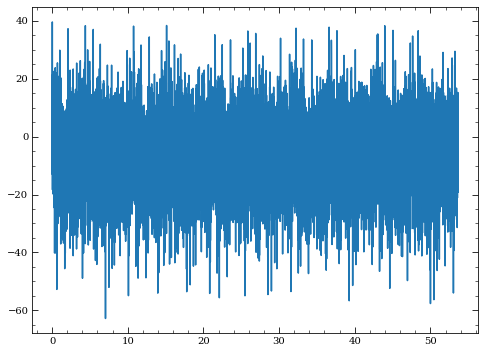

In [146]:
plt.plot(cv_lref, ch_avg_lref)

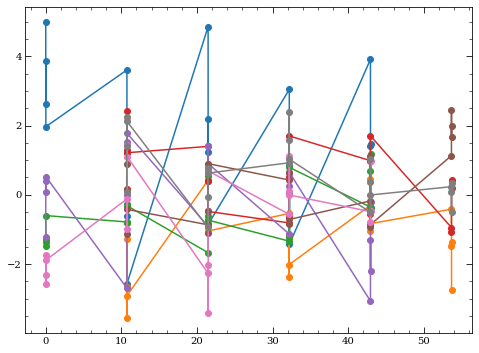

In [133]:
for i in range(nchan):
    plt.plot(cv_bref, ch_avg_bref[i] - np.mean(ch_avg_bref, axis=0), marker='o')
    plt.plot(cv_tref, ch_avg_tref[i] - np.mean(ch_avg_tref, axis=0), marker='o')

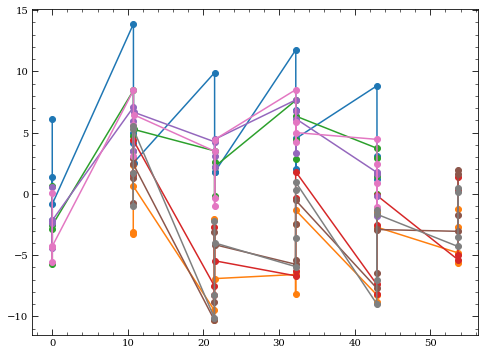

In [127]:
for i in range(nchan):
    plt.plot(cv_bref, ch_avg_bref[i], marker='o')
    plt.plot(cv_tref, ch_avg_tref[i], marker='o')

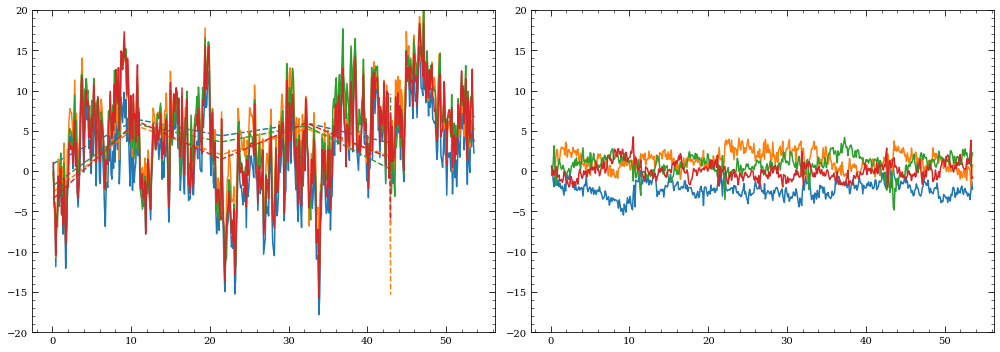

In [81]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

carr = ['C0', 'C1', 'C2', 'C3']

arr_med = np.mean(ch_avg, axis=0)
for i in range(nchan):
    axes[0].plot(cv, ch_avg[i], color=carr[i])
    axes[1].plot(cv, ch_avg[i] - arr_med, color=carr[i])

    
for ax in axes:
    ax.set_ylim([-20,20])
    
fig.tight_layout()

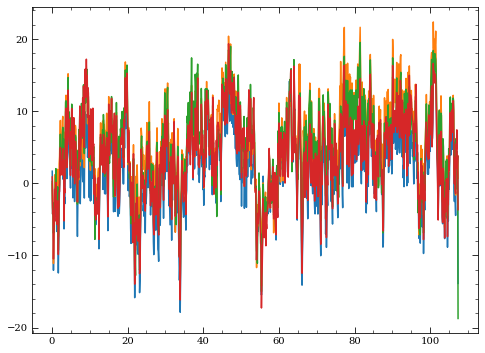

In [60]:
for arr in ch_avg:
    plt.plot(cv, arr)

In [24]:
tvals_ch = tmap[0,:,0:chsize]
data_ch = data[0,:,0:chsize]

mask_out = np.abs(data_ch) > 5*robust.std(data_ch)
ch_smth = channel_smooth_savgol(data_ch, winsize=127, mask=mask_out)

In [108]:
3 % 2

1

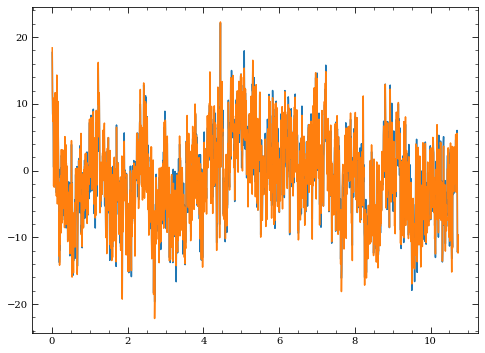

In [104]:
plt.plot(cv, test)
plt.plot(cv, test2)

In [82]:
tbins

array([0.00000000e+00, 2.55795898e-04, 5.11591797e-04, ...,
       5.23358408e-01, 5.23614204e-01, 5.23870000e-01])

(-100, 100)

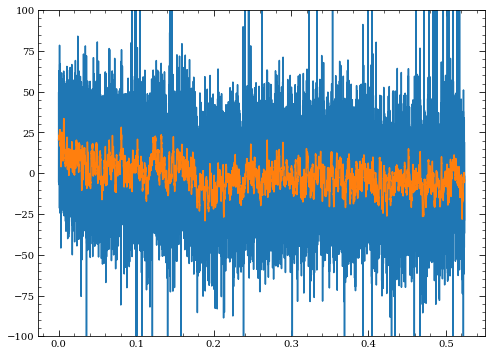

In [72]:
plt.plot(tvals_ch[:100,:].ravel(), data_ch[:100,:].ravel())
plt.plot(tvals_ch[:100,:].ravel(), ch_smth[:100,:].ravel())
# plt.plot(tvals_ch[:1000,:].ravel(), ch_smth2[:1000,:].ravel())
plt.ylim([-100,100])

In [ ]:
# We want to flag column jumps
# Subtract relative to super_dark_ramp

In [270]:
# cf = jl_poly_fit(tarr, data)
temp = (data[-1] - super_dark_ramp[-1]) - (data[0] - super_dark_ramp[0])
temp = np.median(temp, axis=0)

In [20]:
f = allfits[5]
hdul = fits.open(indir + f)
data = hdul[0].data.astype(np.float)
hdul.close()

In [25]:
data -= super_bias
data = reffix_hxrg(data, **kwargs)

In [26]:
data_ymed = np.median(data-super_dark_ramp, axis=1)

In [27]:
data_ymed -= np.median(data_ymed, axis=0)

In [28]:
for ch in range(nchan):
    x1 = ch*chsize
    x2 = x1 + chsize
    data_ymed[:,x1:x2] -= np.median(data_ymed[:,x1:x2], axis=1).reshape([-1,1])

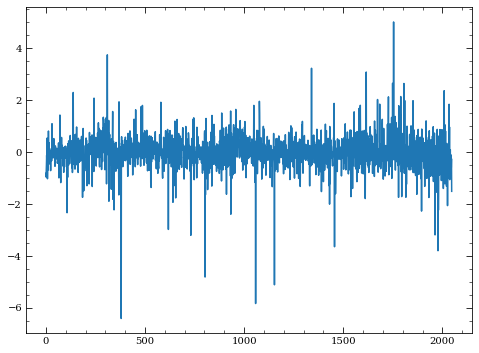

In [29]:
plt.plot(data_ymed[2,:])

In [46]:
dymed = ramp_derivative(data_ymed, fit0=False)
print(data_ymed.shape, dymed.shape)

(108, 2048) (108, 2048)


In [45]:
robust.medabsdev(data_ymed, axis=0)

array([0.80448537, 0.9125583 , 0.74981158, ..., 1.73641682, 0.82872366,
       1.01337328])

In [120]:
# Determine which columns have excursions
ymed_avg = np.mean(data_ymed, axis=0)
ymed_std = np.std(data_ymed, axis=0)

dymed_avg = np.mean(dymed, axis=0)
dymed_std = np.std(dymed, axis=0)

print(np.median(ymed_avg), np.median(ymed_std))
print(robust.std(ymed_avg), robust.std(ymed_std))

mask_outliers1 = np.abs(ymed_avg) > np.median(ymed_avg) + 1*robust.std(ymed_avg)
mask_outliers2 = ymed_std > np.median(ymed_std) + 1*robust.std(ymed_std)
mask_outliers = mask_outliers1 | mask_outliers2
mask_outliers[:4] = False
mask_outliers[-4:] = False

0.0013613762641485369 0.48377151801682206
0.08418422383044617 0.1174302333177209


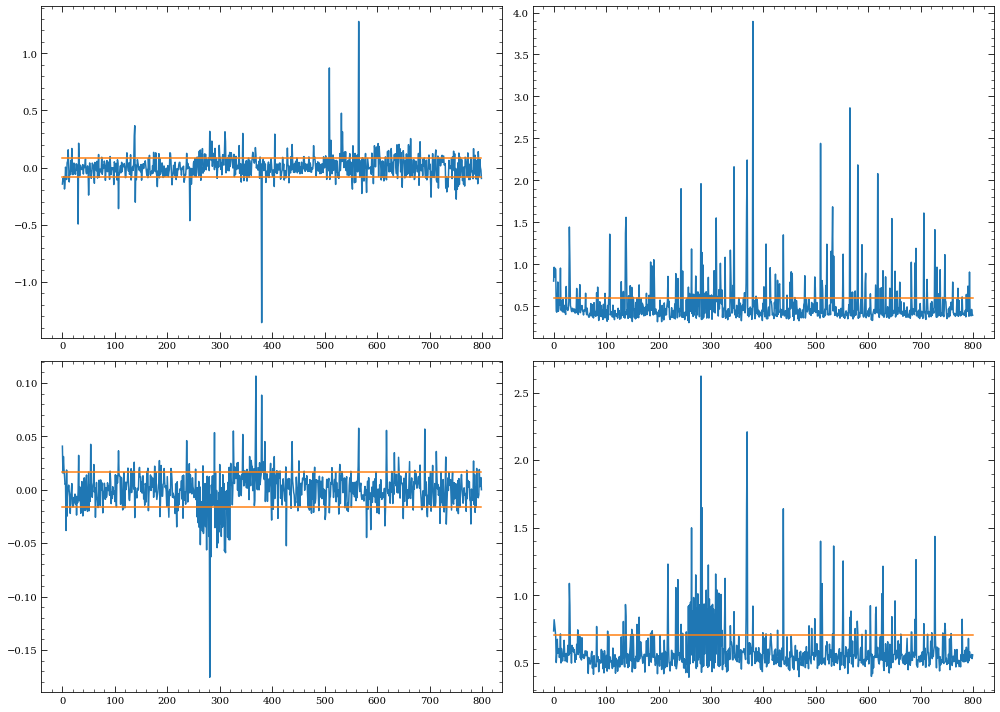

In [122]:
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()

i = 0
nplot = 800


ax = axes[0]
val = ymed_avg
ax.plot(val[i:i+nplot])
ax.plot([0,nplot-1], np.median(val)*np.array([1,1]) - 1*robust.std(val), color='C1')
ax.plot([0,nplot-1], np.median(val)*np.array([1,1]) + 1*robust.std(val), color='C1')

ax = axes[1]
val = ymed_std
ax.plot(val[i:i+nplot])
ax.plot([0,nplot-1], np.median(val)*np.array([1,1]) + 1*robust.std(val), color='C1')

ax = axes[2]
val = dymed_avg
ax.plot(val[i:i+nplot])
ax.plot([0,nplot-1], np.median(val)*np.array([1,1]) - 1*robust.std(val), color='C1')
ax.plot([0,nplot-1], np.median(val)*np.array([1,1]) + 1*robust.std(val), color='C1')

ax = axes[3]
val = dymed_std
ax.plot(val[i:i+nplot])
ax.plot([0,nplot-1], np.median(val)*np.array([1,1]) + 1*robust.std(val), color='C1')


fig.tight_layout()

In [104]:
data_ymed_outliers = data_ymed[:,mask_outliers]
dymed_outliers = dymed[:,mask_outliers]

data_ymed_good = data_ymed[:,~mask_outliers]
dymed_good = dymed[:,~mask_outliers]

In [106]:
imax = np.argwhere(np.abs(data_ymed_outliers) == np.abs(data_ymed_outliers).max())

In [116]:
print(data_ymed_outliers.shape, data_ymed_good.shape)

(108, 813) (108, 1235)


In [107]:
imax

array([[ 52, 367]])

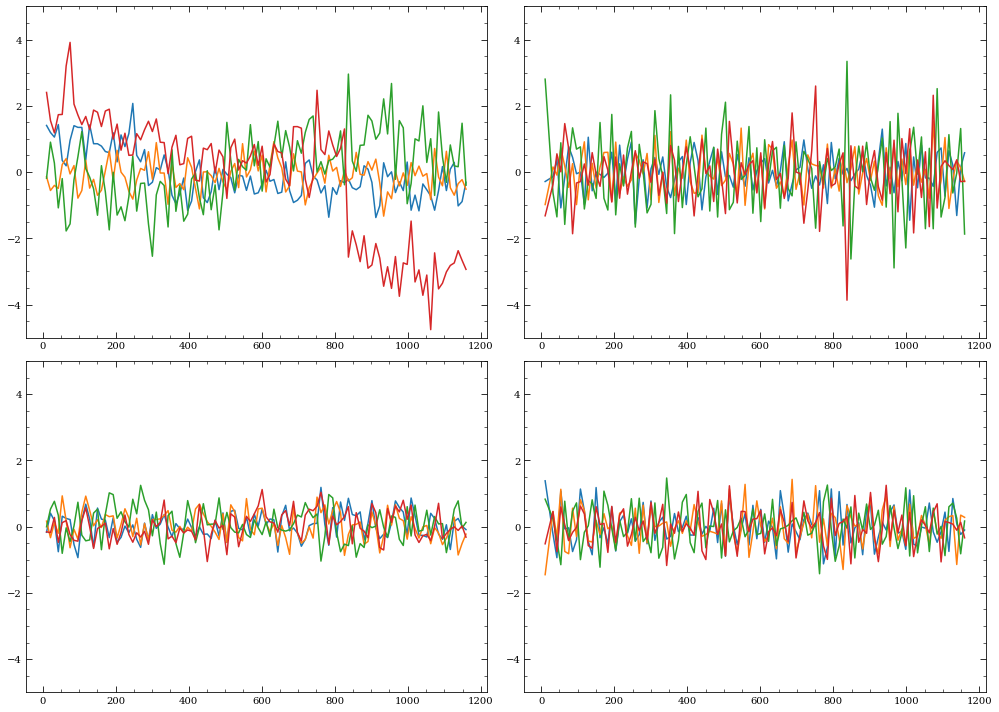

In [136]:
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()

i0 = 510
nplot = 4

ax = axes[0]
for i in range(nplot):
    ax.plot(tarr, data_ymed_outliers[:,i0+i])

ax = axes[1]
for i in range(nplot):
    ax.plot(tarr, dymed_outliers[:,i0+i])

    
ax = axes[2]
for i in range(nplot):
    ax.plot(tarr, data_ymed_good[:,i0+i])

ax = axes[3]
for i in range(nplot):
    ax.plot(tarr, dymed_good[:,i0+i])

for ax in axes:
    ax.set_ylim([-5,5])
    
fig.tight_layout()

In [ ]:
# For each "bad" column, determine number of excursions and 

In [ ]:
def fet_rtn_model(tarr, amplitude, period):
    
    vals = np.zeros_like(tarr)
    

In [154]:
# Look at histograms of excursion amplitude

xvals = data_ymed_outliers
bins = np.linspace(xvals.min(), xvals.max(), num=200)
ig, vg, cv1 = nrc_utils.hist_indices(xvals, bins=bins, return_more=True)
nvals1 = np.array([len(i) for i in ig])

xvals = data_ymed_good
bins = np.linspace(xvals.min(), xvals.max(), num=200)
ig, vg, cv2 = nrc_utils.hist_indices(xvals, bins=bins, return_more=True)
nvals2 = np.array([len(i) for i in ig])

# Normalized distribution
#nvals_norm = nvals / nvals.sum()

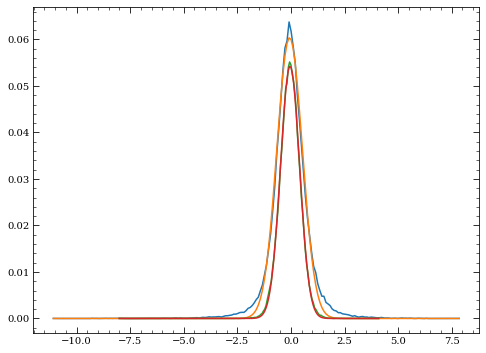

In [155]:
from astropy.modeling import models, fitting

x,y = (cv1, nvals1 / nvals1.sum())
g_init = models.Gaussian1D(amplitude=0.1, stddev=1)
fit_g = fitting.LevMarLSQFitter()
g_func = fit_g(g_init, x, y)

plt.plot(x,y)
plt.plot(x,g_func(x))

x,y = (cv2, nvals2 / nvals2.sum())
g_init = models.Gaussian1D(amplitude=0.1, stddev=1)
fit_g = fitting.LevMarLSQFitter()
g_func = fit_g(g_init, x, y)

plt.plot(x,y)
plt.plot(x,g_func(x))


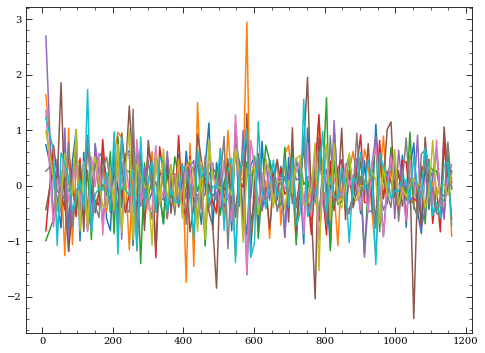

In [43]:
for i in range(10):
    plt.plot(tarr, dymed[:,i+400])

In [321]:
cf = jl_poly_fit(tarr, data_ymed)

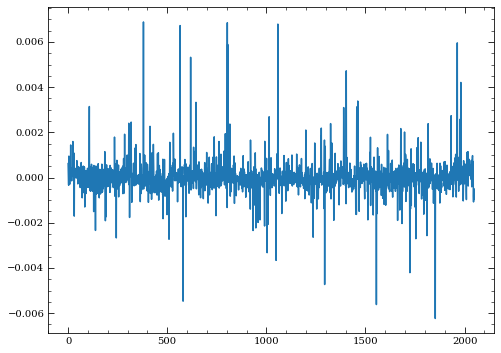

In [324]:
plt.plot(cf[1])

In [325]:
imax

380

In [322]:
imax = np.where(np.abs(cf[1]) == np.abs(cf[1]).max())[0][0]

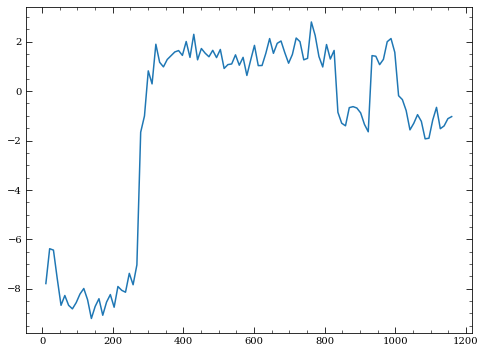

In [323]:
plt.plot(tarr, data_ymed[:,imax])

In [274]:
imax = np.where(temp == temp.max())[0][0]

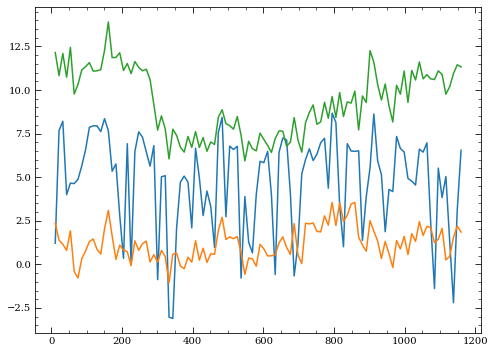

In [284]:
plt.plot(tarr, data_ymed[:,imax])
plt.plot(tarr, data_ymed[:,imax-1])
plt.plot(tarr, data_ymed[:,imax+1])

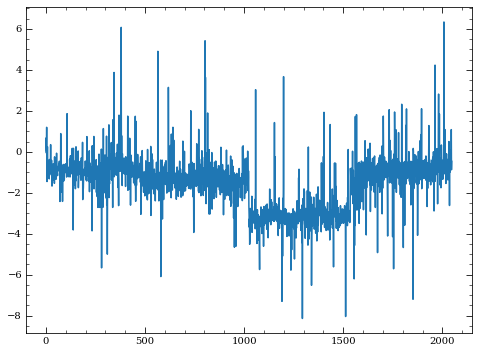

In [271]:
ind = 

In [256]:
cf = jl_poly_fit(tarr, temp)

0.028220361989823518


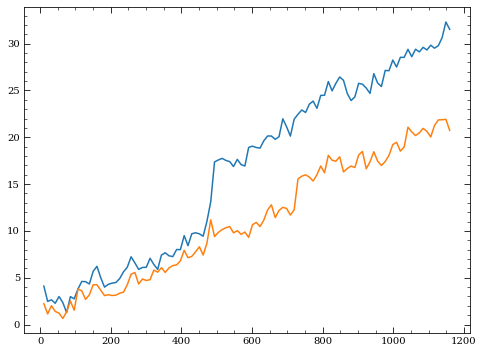

In [265]:
ind = np.where(cf[1] == cf[1].max())[0]
print(cf[1].max())

plt.plot(tarr, temp[:,ind[0]])
plt.plot(tarr, np.median(temp, axis=1))

In [240]:
dark_all_sub = dark_all - dark_mean2
for im in dark_all_sub:
    im -= np.median(im)
xvals = np.median(dark_all_sub[:,5:-5,5:-5], axis=1)

# bins = np.linspace(xvals.min(), xvals.max(), num=200)
ig, vg, cv = nrc_utils.hist_indices(xvals, bins=200, return_more=True)
nvals = np.array([len(i) for i in ig])

# Normalized distribution
nvals_norm = nvals / nvals.sum()

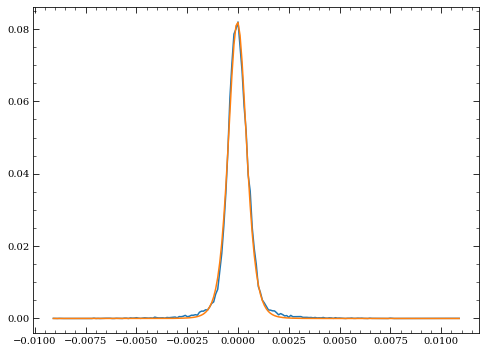

In [220]:
from astropy.modeling import models, fitting

x,y = (cv, nvals / nvals.sum())
g_init = models.Moffat1D(amplitude=0.1, gamma=0.001)
fit_g = fitting.LevMarLSQFitter()
g_func = fit_g(g_init, x, y)

plt.plot(x,y)
plt.plot(x,g_func(x))

In [222]:
g_func(x).sum()

0.9734033844893437

In [244]:
parr = nvals_norm
rand = np.random.choice(x, size=(2048,2048), replace=True, p=parr)

xdel = x[1]-x[0]
rand += np.random.random(size=(2048,2048))*xdel


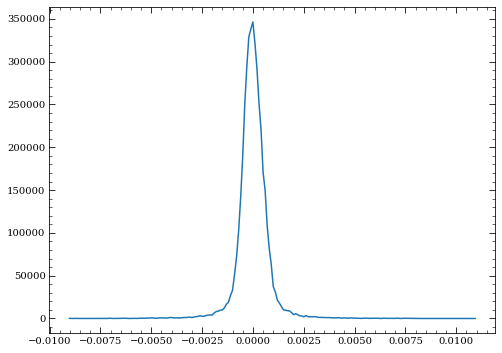

In [245]:
ig, vg, cv = nrc_utils.hist_indices(rand, bins=200, return_more=True)
nvals = np.array([len(i) for i in ig])

plt.plot(cv, nvals)

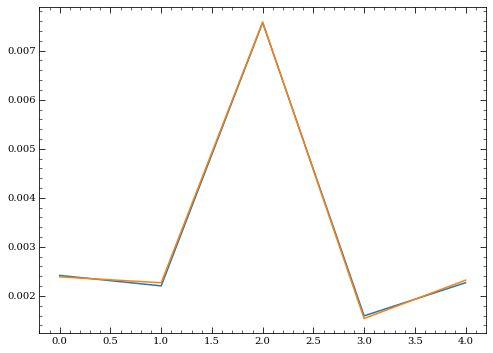

In [210]:
im = dark_all[1] - dark_mean2
y_act = robust.mean(im[5:-4,5:10], axis=0)
y_act2 = np.median(im[5:-4,5:10], axis=0)
y_ref1 = robust.mean(im[0:4,5:10], axis=0)
y_ref2 = robust.mean(im[-4:,5:10], axis=0)
y_ref = (y_ref1 + y_ref2) / 2

plt.plot(y_act)
plt.plot(y_act2)
# plt.plot(y_act - y_ref)

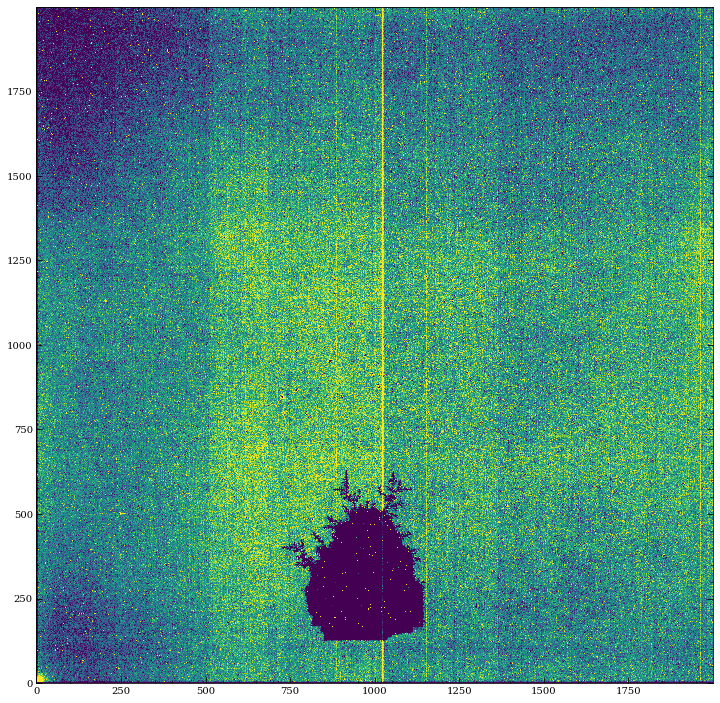

In [104]:
diff = cf0[1] #data[5] - data[4]
med = np.median(diff)
std = robust.std(diff)

# Reshape into [nchans,ny,chsize]
cube = diff.reshape([ny,nchan,-1]).transpose([1,0,2])
mask = np.abs(cube) > med + 10*std

cube = cube - pynrc.ref_pixels.channel_smooth_savgol(cube, per_line=False, mode='interp', mask=mask)
im = cube.transpose([1,0,2]).reshape([ny,nx])

im = diff
med = np.median(im)
std = robust.std(im)

vmin = med - 2*std
vmax = med + 2*std

fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.imshow(diff[0:2000,0:2000], vmin=vmin, vmax=vmax)

fig.tight_layout()

In [56]:
im = cube[0]
nans = np.isnan(im)

In [60]:
from scipy.signal import savgol_filter

In [61]:
im_mask = mask[0].flatten()

im=cube[0].flatten()
im = np.copy(im)

# Use a savgol filter to smooth out any outliers
res = im.copy()
res[~im_mask] = savgol_filter(im[~im_mask], 31, 3, mode='interp')


ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

In [18]:
%time ramp_med = np.median(super_dark_ramp.reshape([nz,-1]), axis=1)

CPU times: user 7.76 s, sys: 1.61 s, total: 9.37 s
Wall time: 9.39 s


In [24]:
iy, ix = np.where(super_bias>30000)

In [25]:
print(iy,ix)

[   4    4    5 ... 2043 2043 2043] [ 989 1222   81 ...  530  590 1557]


In [26]:
iy, ix = 1870,752
iy, ix = 4, 989
super_bias[iy, ix]

31993.458506863502

31993.458506863502


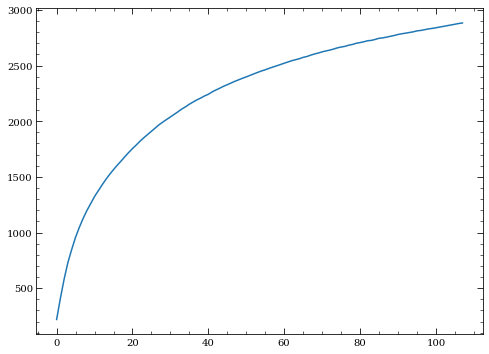

In [27]:

print(super_bias[iy, ix])
plt.plot(super_dark_ramp[:,iy, ix])

In [5]:
# Check linearity over flux range
plt.plot(tarr, ramp_med, marker='.', label='Pixel Median')

ind = tarr<200
cf = jl_poly_fit(tarr[ind], ramp_med[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

ind = tarr>200
cf = jl_poly_fit(tarr[ind], ramp_med[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))


plt.xlabel('Time (sec)')
plt.ylabel('Dark Value (DN)')
plt.title('Dark Current (SCA {})'.format(scaid))
plt.legend()
# plt.plot(tarr, ramp_avg2, marker='.', ls='none', color='C1')
# bias, slope2 = jl_poly_fit(tarr, ramp_avg2)
# plt.plot(tarr, tarr*slope2, color='C1')

# print(np.median(super_bias), np.median(super_dark), cf[1])

NameError: name 'plt' is not defined

1166.4249533983634 0.01872237275437635 0.01900762935236517


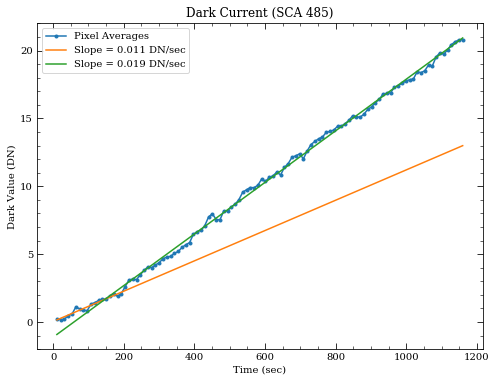

In [96]:

# print(np.median(super_bias0), np.median(super_dark2))

# Check linearity over flux range
plt.plot(tarr, ramp_med, marker='.', label='Pixel Median')

ind = tarr<200
cf = jl_poly_fit(tarr[ind], ramp_med[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

ind = tarr>200
cf = jl_poly_fit(tarr[ind], ramp_med[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))


plt.xlabel('Time (sec)')
plt.ylabel('Dark Value (DN)')
plt.title('Dark Current (SCA {})'.format(scaid))
plt.legend()
# plt.plot(tarr, ramp_avg2, marker='.', ls='none', color='C1')
# bias, slope2 = jl_poly_fit(tarr, ramp_avg2)
# plt.plot(tarr, tarr*slope2, color='C1')

print(np.median(super_bias), np.median(super_dark), cf[1])

(108, 15255)


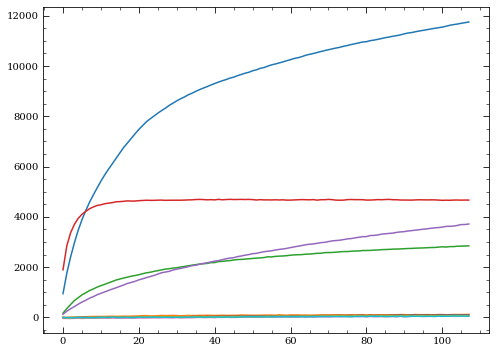

In [23]:
mask = masks_dict['mask_deviant']
ind = mask.sum(axis=0)>2

temp = data[:,ind]
print(temp.shape)

for i in range(10):
    plt.plot(temp[:,i+8])

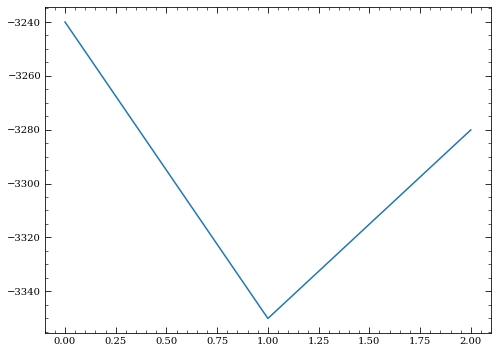

In [35]:
vals = bias_off_all[:,ind]
plt.plot(vals[:,8])

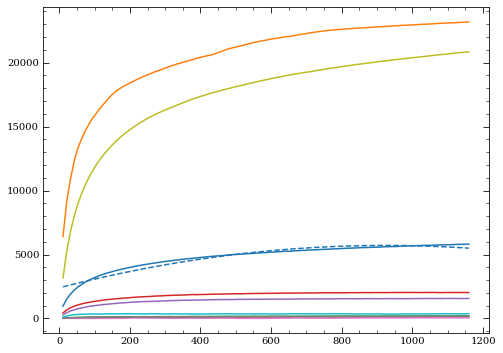

In [36]:
ulg = False

ii = 8
plt.plot(tarr, temp[:,ii:ii+10])
cf = jl_poly_fit(tarr, temp[:,ii], deg=2, use_legendre=ulg)
plt.plot(tarr, jl_poly(tarr,cf, use_legendre=ulg), ls='--')

# print('Red Chi Sqr:', chired_poly[ind][ii])

47.64974648586758
1.7322827453404591e-13


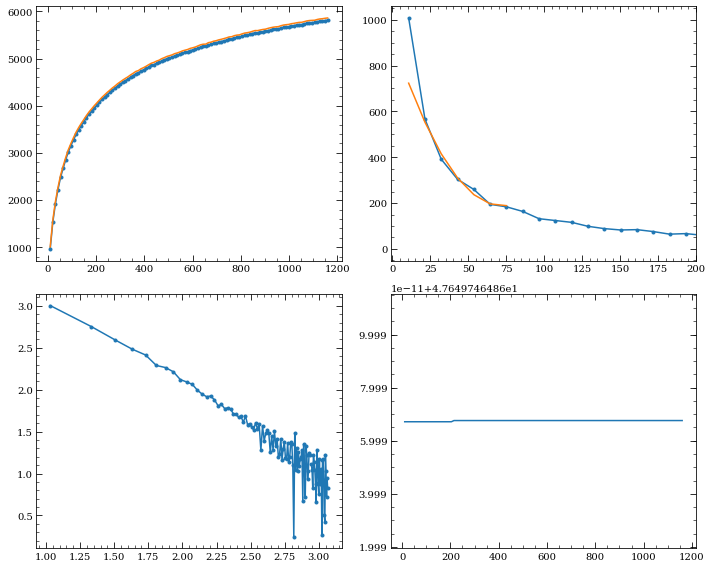

In [37]:
fig, axes = plt.subplots(2,2,figsize=(10,8))
axes = axes.flatten()

ii = 8
x = tarr
y = temp[:,ii]

ax = axes[0]
ax.plot(x, y, marker = '.')

# dy = np.gradient(y)
# dy[0] = dy[1] - (dy[2] - dy[1])

# dy = y[1:] - y[:-1]
# dy = np.insert(dy, 0, 2*dy[0] - dy[1])

i1, i2 = [0,5]
deg = 2
dy = ramp_derivative(y, fit0=True, deg=deg, ifit=[i1,i2])
cf_dy = jl_poly_fit(x[i1+1:i2+2], dy[i1+1:i2+2], deg=deg)

ax = axes[1]
ax.plot(x, dy, marker='.')
ax.plot(x[i1:i2+2], jl_poly(x[i1:i2+2],cf_dy))
ax.set_xlim([-1,200])


ax = axes[2]
ax.plot(np.log10(x), np.log10(dy), marker='.')
# ax.plot(x[i1:i2+2], jl_poly(x[i1:i2+2],cf_dy))
# ax.set_xlim([-1,200])


yfit = np.cumsum(dy)
axes[0].plot(x, yfit)

print(np.median(yfit - y))
print(np.std(yfit - y))

axes[3].plot(x, yfit - y)
xtemp = np.arange(len(dy))+1
fig.tight_layout()


In [79]:
del data, yfit

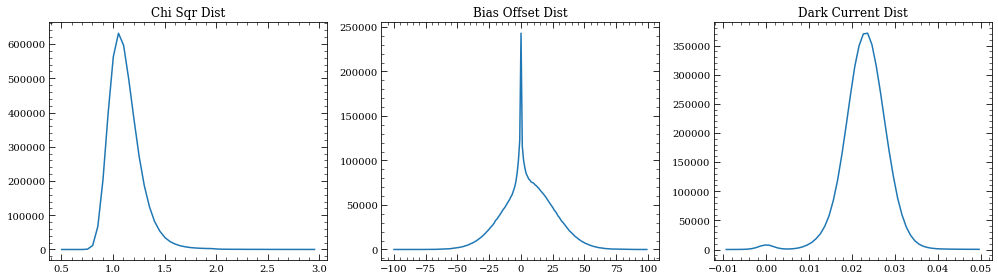

In [27]:
fig, axes = plt.subplots(1,3, figsize=(14,4))


# Plot polynomial chi-sqr histogram
ax = axes[0]
xvals = chired_poly

binsize = 0.05
bins = np.arange(xvals.min(), xvals.max()+binsize, binsize)
ig, vg, cv = nrc_utils.hist_indices(xvals, bins=bins, return_more=True)
nvals = np.array([len(i) for i in ig])

iplt = cv<3
ax.plot(cv[iplt], nvals[iplt])

# Plot bias offset histogram
ax = axes[1]
xvals = bias_off

binsize = 1
bins = np.arange(xvals.min(), xvals.max()+binsize, binsize)
ig, vg, cv = nrc_utils.hist_indices(xvals, bins=bins, return_more=True)
nvals = np.array([len(i) for i in ig])

iplt = (cv>-100) & (cv<100)
ax.plot(cv[iplt], nvals[iplt])

# Plot slope histogram
ax = axes[2]
xvals = cf_all[1]

binsize = 0.001
bins = np.arange(xvals.min(), xvals.max()+binsize, binsize)
ig, vg, cv = nrc_utils.hist_indices(xvals, bins=bins, return_more=True)
nvals = np.array([len(i) for i in ig])

iplt = (cv>-0.01) & (cv<0.05)
ax.plot(cv[iplt], nvals[iplt])

ax_titles = ['Chi Sqr Dist', 'Bias Offset Dist', 'Dark Current Dist']
for i, ax in enumerate(axes):
    ax.set_title(ax_titles[i])

fig.tight_layout()

In [290]:
ind = (~mask_poly) & (~mask_ref) & (~mask_deviant) & (~mask_negative)
# ind2 = ~(ind | mask_poly | mask_ref)

In [30]:
temp = data[:,mask_deviant]
temp.shape

(108, 23003)

NameError: name 'ind' is not defined

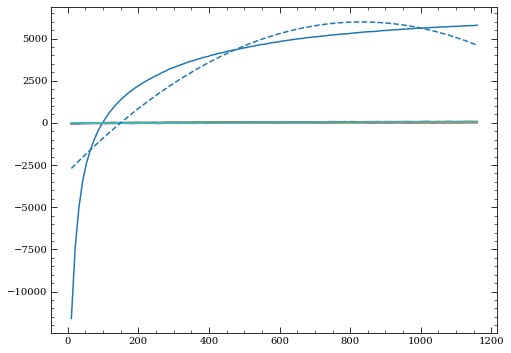

In [31]:
ulg = False

ii = 100
plt.plot(tarr, temp[:,ii:ii+10])
cf = jl_poly_fit(tarr, temp[:,ii], deg=2, use_legendre=ulg)
plt.plot(tarr, jl_poly(tarr,cf, use_legendre=ulg), ls='--')

print('Red Chi Sqr:', chired_poly[ind][ii])

24112.394355659428
6.697131549534037e-12


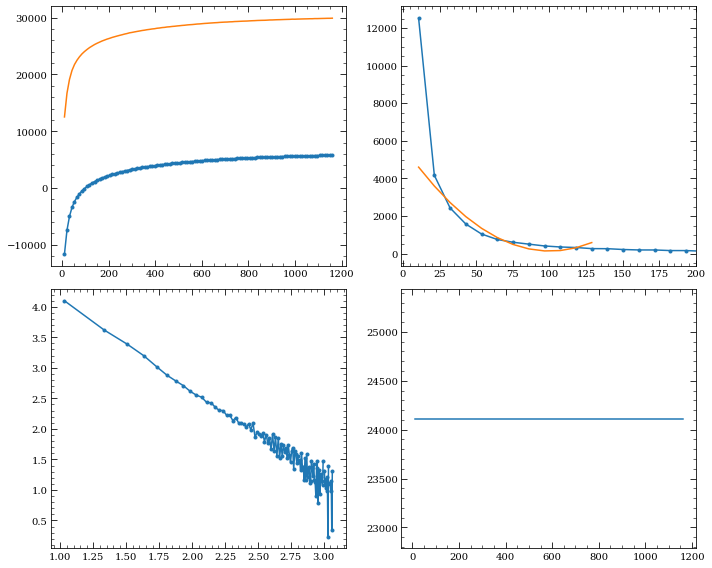

In [32]:
fig, axes = plt.subplots(2,2,figsize=(10,8))
axes = axes.flatten()

ii = 100
x = tarr
y = temp[:,ii]

ax = axes[0]
ax.plot(x, y, marker = '.')

# dy = np.gradient(y)
# dy[0] = dy[1] - (dy[2] - dy[1])

# dy = y[1:] - y[:-1]
# dy = np.insert(dy, 0, 2*dy[0] - dy[1])

i1, i2 = [0,10]
deg = 2
dy = ramp_derivative(y, fit0=True, deg=deg, ifit=[i1,i2])
cf_dy = jl_poly_fit(x[i1+1:i2+2], dy[i1+1:i2+2], deg=deg)

ax = axes[1]
ax.plot(x, dy, marker='.')
ax.plot(x[i1:i2+2], jl_poly(x[i1:i2+2],cf_dy))
ax.set_xlim([-1,200])


ax = axes[2]
ax.plot(np.log10(x), np.log10(dy), marker='.')
# ax.plot(x[i1:i2+2], jl_poly(x[i1:i2+2],cf_dy))
# ax.set_xlim([-1,200])


yfit = np.cumsum(dy)
axes[0].plot(x, yfit)

print(np.median(yfit - y))
print(np.std(yfit - y))

axes[3].plot(x, yfit - y)
xtemp = np.arange(len(dy))+1
fig.tight_layout()


In [81]:
ind = ig[np.where(cv<1)[0][0]]
temp = data.reshape([nz,-1])[:, ind]

In [78]:
temp = data[:,~mask_ref][:,ind]

In [75]:
ind = (chired_lin > 2) & (chired_lin < 3)
ind = (chired_lin > 0.9) & (chired_lin < 1.1)
# ind = data[0] < -50
temp = data[:,ind]

In [167]:
data -= bias_off

In [28]:
mask = (cf[1] > 0.02) & (cf[1] < 0.1)
temp = data[:,mask]

In [29]:
temp.shape

(108, 0, 2048, 2048)

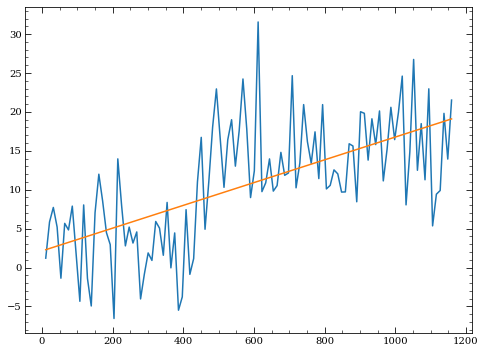

In [27]:
ulg = False

ii = 0
plt.plot(tarr, temp[:,ii])
cf = jl_poly_fit(tarr, temp[:,ii], deg=1, use_legendre=ulg)
plt.plot(tarr, jl_poly(tarr,cf, use_legendre=ulg))

-25.73967811267251
3.296778768694029e-15


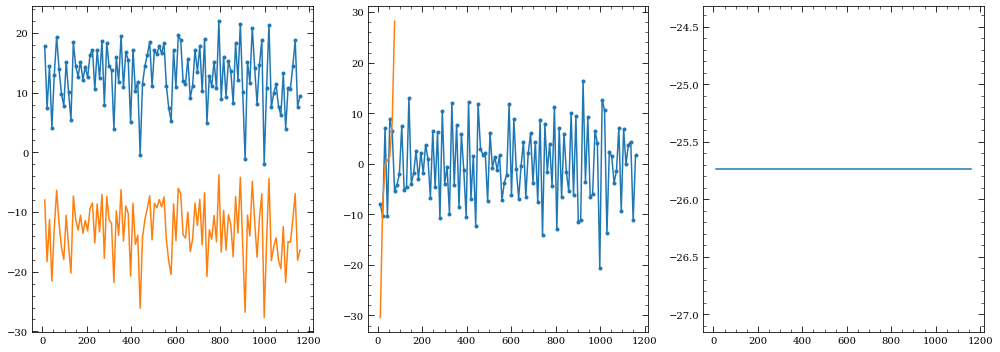

In [161]:
fig, axes = plt.subplots(1,3,figsize=(14,5))

ii = 0
x = tarr
y = temp[:,ii]

ax = axes[0]
ax.plot(x, y, marker = '.')

# dy = np.gradient(y)
# dy[0] = dy[1] - (dy[2] - dy[1])

# dy = y[1:] - y[:-1]
# dy = np.insert(dy, 0, 2*dy[0] - dy[1])

dy = ramp_derivative(y, fit0=True, deg=3)
cf_dy = jl_poly_fit(x[1:6], dy[1:6], deg=3)

ax = axes[1]
ax.plot(x, dy, marker='.')
ax.plot(x[:7], jl_poly(x[:7],cf_dy))

yfit = np.cumsum(dy)
axes[0].plot(x, yfit)

print(np.median(yfit - y))
print(np.std(yfit - y))

axes[2].plot(x, yfit - y)

fig.tight_layout()


In [128]:
y = np.array([0, 5, 3, 8,7, 10, 20])
dy = y[1:] - y[:-1]
dy = np.insert(dy,0,0)
y2 = dy.cumsum()
print(y2)

[ 0  5  3  8  7 10 20]


In [31]:
# Create a super dark ramp
ramp_sum = np.zeros([nz,ny,nx]) # Ignore outliers
ramp_sum2 = np.zeros([nz,ny,nx]) # Do all
nsum = np.zeros([ny,nx])
for i in trange(nfiles):
    f = allfits[i]
    hdul = fits.open(indir + f)
    data = hdul[0].data.astype(np.float)
    hdul.close()

    data -= super_bias
    data = reffix_hxrg(data, nchans=4, altcol=True, in_place=True, 
                       fixcol=True, avg_type='pixel', savgol=True, perint=True)

    # Get redsidual bias
    bias, slope = jl_poly_fit(tarr, data)
    data -= bias

    deg = 1 #kwargs['deg']
    cf = jl_poly_fit(tarr, data, deg=deg)

    # Find slope outliers to exclude (10-sigma)
    mask = robust.mean(cf[1], return_mask=True, Cut=10).reshape(ny,nx)
    mask[:4,:] = 1
    mask[:,:4] = 1
    mask[-4:,:] = 1
    mask[:,-4:] = 1

    igood = (mask==1)
    
    nsum += mask

    for j, im in enumerate(data):
        ramp_sum[j][igood] += im[igood]
    ramp_sum2 += data

    del data
    


In [32]:
# Take averages
igood = nsum>1
for im in ramp_sum:
    im[igood] /= nsum[igood]
    
ramp_sum2 /= nfiles

In [144]:
cut_off = 1
igood = nsum>cut_off
ibad = nsum<=cut_off

ind_good = np.where(igood.flatten())[0]
ind_bad = np.where(ibad.flatten())[0]

In [33]:
bins = np.arange(nfiles+1)
ig, vg, cv = nrc_utils.hist_indices(nsum, bins=bins, return_more=True)
nvals = np.array([len(i) for i in ig])

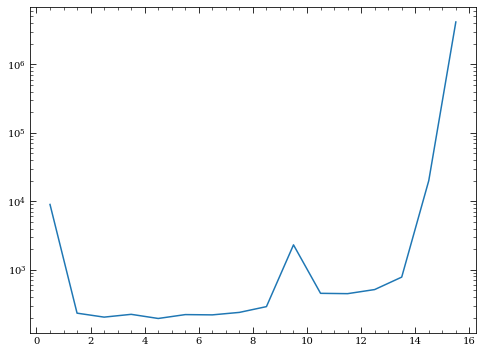

In [34]:
plt.semilogy(cv, nvals)

In [35]:
ig[0]

array([   8196,    8197,    8198, ..., 4184866, 4184867, 4185642],
      dtype=int32)

0.3419667206071608
239.8645077913759


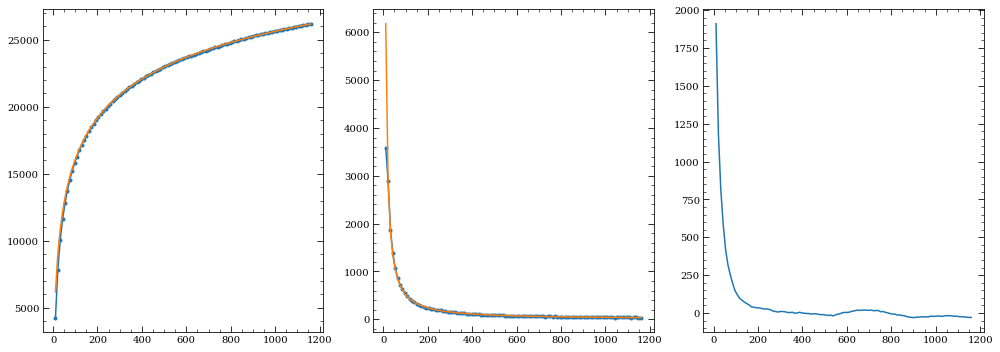

In [115]:
temp = ramp_sum.reshape([nz,-1])
temp2 = ramp_sum2.reshape([nz,-1])

fig, axes = plt.subplots(1,3,figsize=(14,5))

ind = ig[0]
i = ind[60]

x = tarr
y = temp2[:,i]
y -= y[0]
y += (y[1]-y[0])
y += 686

ax = axes[0]
ax.plot(x, y, marker = '.')

dy = np.gradient(y)
dlogdy = np.gradient(np.log(dy))

ax = axes[1]
xl, dyl = np.log10(x), np.log10(dy)
ax.plot(x, dy, marker='.')

cfl = jl_poly_fit(xl[1:],dyl[1:])
#plt.plot(10**xl, )

dy_fit = 10**jl_poly(xl, cfl)
ax.plot(x, dy_fit)

yfit = np.cumsum(dy_fit)
axes[0].plot(x, yfit)

print(np.median(yfit - y))
print(np.std(yfit - y))

axes[2].plot(x, yfit - y)

fig.tight_layout()

# plt.xlim([0,100])
# plt.ylim([0,15000])

In [278]:
diff = (ramp_sum2[-1] - ramp_sum2[1]).ravel()
binsize = 100
bins = np.arange(diff.min(), diff.max()+binsize, binsize)
ig, vg, cv = nrc_utils.hist_indices(diff, bins=bins, return_more=True)
nvals = np.array([len(i) for i in ig])

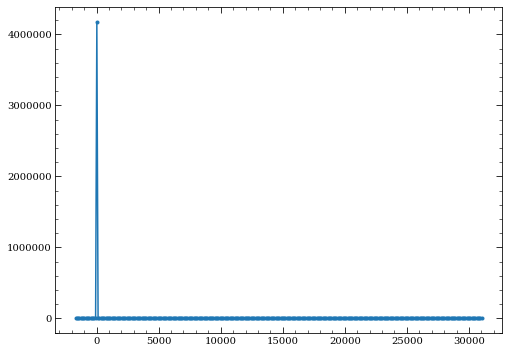

In [279]:
plt.plot(cv, nvals, marker='.')

In [280]:
ind = np.where(cv>10000)[0]
ind_pix = ig[ind[0]]

In [281]:
rc_pix = temp2[:,ind_pix]

In [282]:
rc_pix.shape

(108, 22)

In [277]:
chi_tot*err

270.0665326949239

6978.976922553396


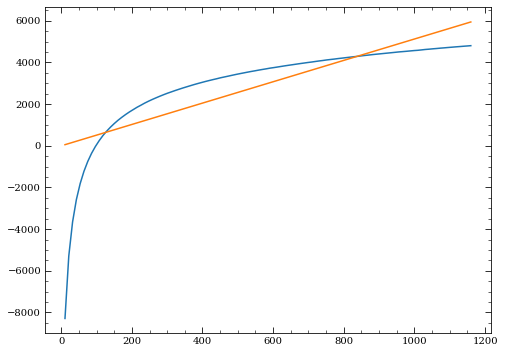

In [284]:
x, y = tarr, rc_pix[:,1]
plt.plot(x,y)

cf = jl_poly_fit(x,y, deg=1, use_legendre=False)
yfit = jl_poly(x,cf, use_legendre=False)
# Calculate chi-square
diff = y - yfit
err = robust.std(y[1:] - y[0:-1]) / np.sqrt(2)
dev = diff / err
chi_tot = np.sum(dev**2)
chi_red = chi_tot / (len(dev) - len(cf))

plt.plot(x,yfit)

print(chi_red)

In [286]:
from scipy.stats import chisquare
chisquare(y,f_exp=yfit,ddof=2)

Power_divergenceResult(statistic=1702923.395792621, pvalue=0.0)

In [ ]:
from scipy.stats import t

In [216]:
err

1.1063383713916932

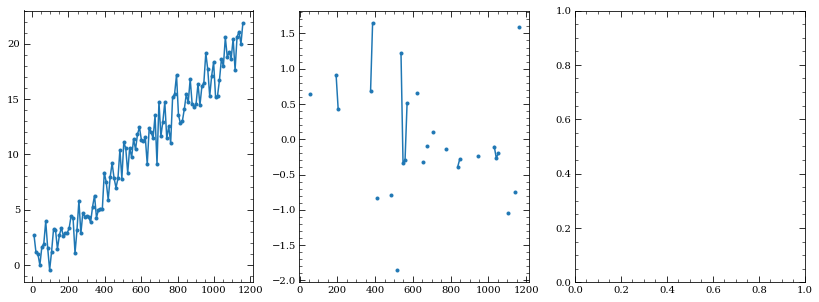

In [121]:
temp = ramp_sum.reshape([nz,-1])
temp2 = ramp_sum2.reshape([nz,-1])

fig, axes = plt.subplots(1,3,figsize=(14,5))

x = tarr
y = ramp_sum2[:,100,400]

ax = axes[0]
ax.plot(x, y, marker = '.')


dy = np.gradient(y)
dlogdy = np.gradient(np.log(dy))

ax = axes[1]
xl, dyl = np.log10(x), np.log10(dy)
ax.plot(x, dy, marker='.')



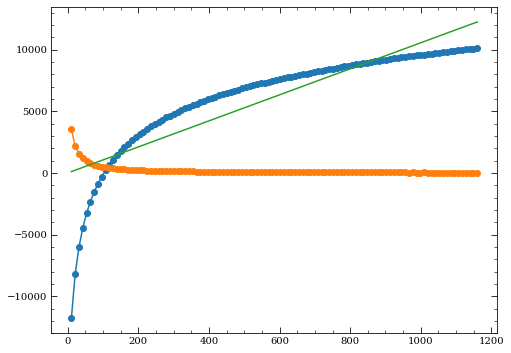

In [38]:
temp = ramp_sum.reshape([nz,-1])
temp2 = ramp_sum2.reshape([nz,-1])

ind = ig[0]
for i in range(1):
#     plt.plot(tarr, temp[:,ind[i+600]])
    y = temp2[:,ind[i+60]]
    dy = np.diff(y, append=y[-1])
    dy[-1] = dy[-2]
    plt.plot(tarr, y, marker='o')
    plt.plot(tarr, dy, marker='o')
    
#     popt, pcov = curve_fit(fit_func, tarr, y, p0=(y.max(), y.max(), 200, y.max(), 200))
    
#     plt.plot(tarr, fit_func(tarr, *popt))
    
    cf = jl_poly_fit(tarr, y, deg=1, use_legendre=True)
    plt.plot(tarr, jl_poly(tarr,cf, use_legendre=True))


In [190]:
from scipy.optimize import curve_fit

In [209]:
def fit_func(x, a, b, c, d, e):
    return a - b*np.exp(-x/c) - d*np.exp(-x/e)

x = tarr
y = temp[:,ind[i+600]]
popt, pcov = curve_fit(fit_func, x, y, p0=(12000, 12000, 200, 12000, 200))

In [274]:
print(np.log(15), np.log(10), np.log(5))

2.70805020110221 2.302585092994046 1.6094379124341003


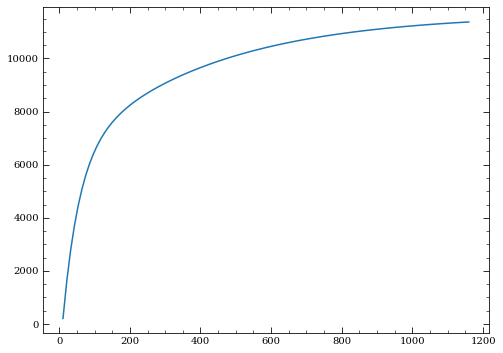

In [211]:
plt.plot(tarr, fit_func(tarr, *popt))

In [279]:
np.diff(y, append=y[-1]).shape

(108,)

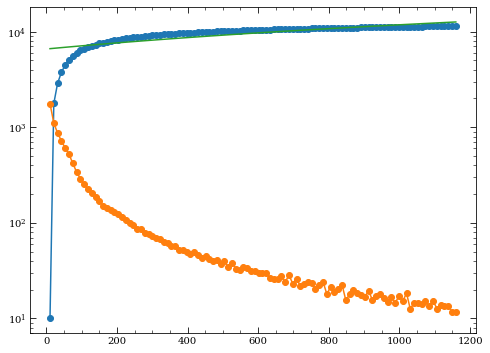

In [299]:
temp = ramp_sum.reshape([nz,-1])
temp2 = ramp_sum2.reshape([nz,-1])

ind = ig[0]
for i in range(1):
#     plt.plot(tarr, temp[:,ind[i+600]])
    y = temp2[:,ind[i+600]]
    dy = np.diff(y, append=y[-1])
    dy[-1] = dy[-2]
    plt.semilogy(tarr, y, marker='o')
    plt.plot(tarr, dy, marker='o')
    
#     popt, pcov = curve_fit(fit_func, tarr, y, p0=(y.max(), y.max(), 200, y.max(), 200))
    
#     plt.plot(tarr, fit_func(tarr, *popt))
    
    cf = jl_poly_fit(tarr, y, deg=1, use_legendre=True)
    plt.plot(tarr, jl_poly(tarr,cf, use_legendre=True))


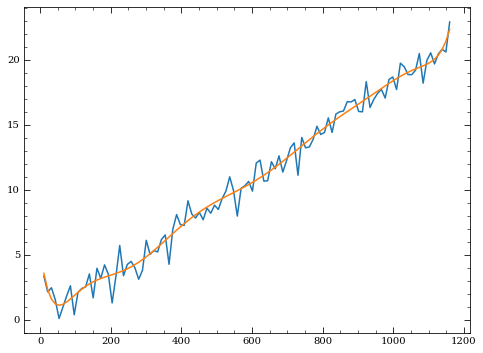

In [270]:
temp = ramp_sum.reshape([nz,-1])
temp2 = ramp_sum2.reshape([nz,-1])

ind = ig[34]
for i in range(1):
#     plt.plot(tarr, temp[:,ind[i+600]])
    y = temp2[:,ind[i+60000]]
    plt.plot(tarr, y)
    
#     popt, pcov = curve_fit(fit_func, tarr, y, p0=(y.max(), y.max(), 200, y.max(), 200))
    
#     plt.plot(tarr, fit_func(tarr, *popt))
    
    cf = jl_poly_fit(tarr, y, deg=10, use_legendre=True, QR=False, robust_fit=True)
    plt.plot(tarr, jl_poly(tarr,cf, use_legendre=True))


In [266]:
cf

array([ 3.71086760e+01,  3.63712480e+01, -5.55727262e+00,  8.64851277e-01,
        2.90743228e-01, -3.18054892e-02, -4.58181329e-01, -4.92751217e-01,
        5.57726255e-01, -1.02998706e-01, -3.89839610e-01])

In [219]:
popt

array([ 392670.58272259,  192655.96926438, 4789373.35800817,
        200014.61535205, 4873270.01614586])

In [82]:
# Calculate super dark image and relative bias diff
super_bias_del, super_dark = jl_poly_fit(tarr, ramp_sum)
super_bias_del2, super_dark2 = jl_poly_fit(tarr, ramp_sum2)

In [75]:
igood = nsum>1
temp = ramp_sum.reshape([nz,-1])
ind = igood.flatten()
%time ramp_avg = np.mean(temp[:,ind], axis=1)

CPU times: user 11.7 s, sys: 1.84 s, total: 13.5 s
Wall time: 13.5 s


In [80]:
nx*ny

4194304

In [79]:
igood[igood].shape

(4176294,)

In [66]:
%time ramp_avg2 = np.median(ramp_sum2.reshape([nz,-1]), axis=1)

CPU times: user 8.59 s, sys: 1.75 s, total: 10.3 s
Wall time: 10.3 s


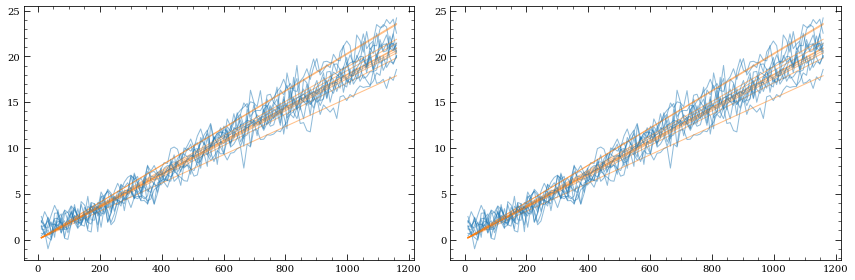

In [69]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

xvals = np.random.randint(5,2000, 10)
yvals = np.random.randint(5,2000, 10)

for i in range(len(xvals)):
    
    pix = ramp_sum[:,int(yvals[i]),int(xvals[i])]
#     pix = pix - np.median(pix)
    cf = jl_poly_fit(tarr,pix, deg=1)

    axes[0].plot(tarr, pix, color='C0', lw=1, alpha=0.5)
    axes[0].plot(tarr, jl_poly(tarr,cf), color='C1', lw=1, alpha=0.5)

for i in range(len(xvals)):

    pix = ramp_sum2[:,int(yvals[i]),int(xvals[i])]
#     pix = pix - np.median(pix)
    cf = jl_poly_fit(tarr,pix, deg=1)

    axes[1].plot(tarr, pix, color='C0', lw=1, alpha=0.5)
    axes[1].plot(tarr, jl_poly(tarr,cf), color='C1', lw=1, alpha=0.5)

    
fig.tight_layout()

1175.0326086032937 0.018256454995918218 0.013934748624570928


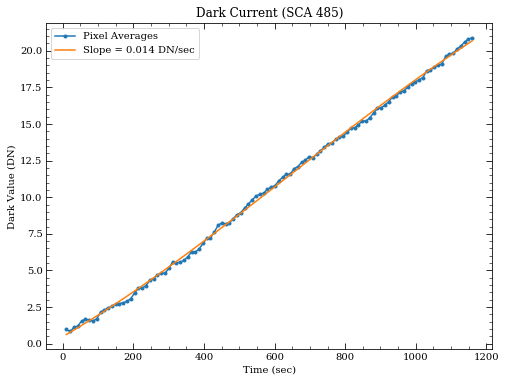

In [123]:

# print(np.median(super_bias0), np.median(super_dark2))

# Check linearity over flux range
plt.plot(tarr, ramp_avg, marker='.', label='Pixel Averages')
# plt.plot(tarr, ramp_avg2, marker='.', label='Pixel Averages2')

cf = jl_poly_fit(tarr, ramp_avg, deg=3)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

# ind = tarr<200
# cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
# plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

# ind = tarr>200
# cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
# plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))


plt.xlabel('Time (sec)')
plt.ylabel('Dark Value (DN)')
plt.title('Dark Current (SCA {})'.format(scaid))
plt.legend()
# plt.plot(tarr, ramp_avg2, marker='.', ls='none', color='C1')
# bias, slope2 = jl_poly_fit(tarr, ramp_avg2)
# plt.plot(tarr, tarr*slope2, color='C1')

print(np.median(super_bias), np.median(super_dark), cf[1])

1166.4249533983634 0.01872237275437635 0.01900762935236517


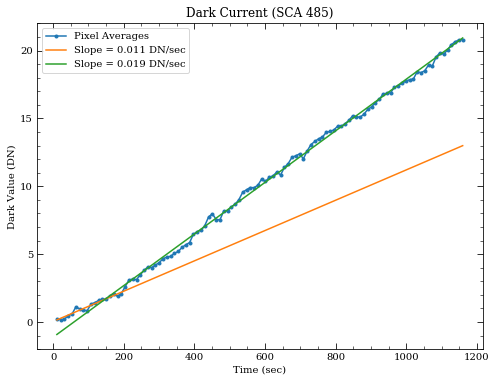

In [96]:

# print(np.median(super_bias0), np.median(super_dark2))

# Check linearity over flux range
plt.plot(tarr, ramp_avg, marker='.', label='Pixel Averages')

ind = tarr<200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

ind = tarr>200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))


plt.xlabel('Time (sec)')
plt.ylabel('Dark Value (DN)')
plt.title('Dark Current (SCA {})'.format(scaid))
plt.legend()
# plt.plot(tarr, ramp_avg2, marker='.', ls='none', color='C1')
# bias, slope2 = jl_poly_fit(tarr, ramp_avg2)
# plt.plot(tarr, tarr*slope2, color='C1')

print(np.median(super_bias), np.median(super_dark), cf[1])

In [21]:
# Create a summed super dark
for i, f in enumerate(allfits):
    print(f)
    hdul = fits.open(indir + f)
    data = hdul[0].data.astype(np.float)
    hdul.close()
    
    data -= super_bias
    data = reffix_hxrg(data, nchans=4, altcol=True, in_place=True, 
                       fixcol=True, avg_type='pixel', savgol=True, perint=True)
    
    if i==0:
        data2 = data.copy()
    else:
        data2 += data
    
    del data

# Take the average
data2 /= len(allfits)

NRCNRCALONG-DARK-60011752461_1_485_SE_2016-01-01T19h59m45.fits
NRCNRCALONG-DARK-60020011461_1_485_SE_2016-01-02T02h29m40.fits
NRCNRCALONG-DARK-60020545311_1_485_SE_2016-01-02T07h09m10.fits
NRCNRCALONG-DARK-60081050261_1_485_SE_2016-01-08T11h47m53.fits
NRCNRCALONG-DARK-60081524241_1_485_SE_2016-01-08T17h03m29.fits
NRCNRCALONG-DARK-60082329041_1_485_SE_2016-01-09T00h04m16.fits
NRCNRCALONG-DARK-60090344021_1_485_SE_2016-01-09T04h16m42.fits
NRCNRCALONG-DARK-60090746381_1_485_SE_2016-01-09T08h21m48.fits
NRCNRCALONG-DARK-60091140151_1_485_SE_2016-01-09T14h23m49.fits
NRCNRCALONG-DARK-60091611271_1_485_SE_2016-01-09T17h16m35.fits
NRCNRCALONG-DARK-60200857491_1_485_SE_2016-01-20T11h19m16.fits
NRCNRCALONG-DARK-60201458561_1_485_SE_2016-01-20T15h29m07.fits
NRCNRCALONG-DARK-60221036191_1_485_SE_2016-01-22T11h43m24.fits
NRCNRCALONG-DARK-60260722581_1_485_SE_2016-01-26T08h04m32.fits
NRCNRCALONG-DARK-60261145131_1_485_SE_2016-01-26T12h12m51.fits
NRCNRCALONG-DARK-60270008251_1_485_SE_2016-01-27T01h00m

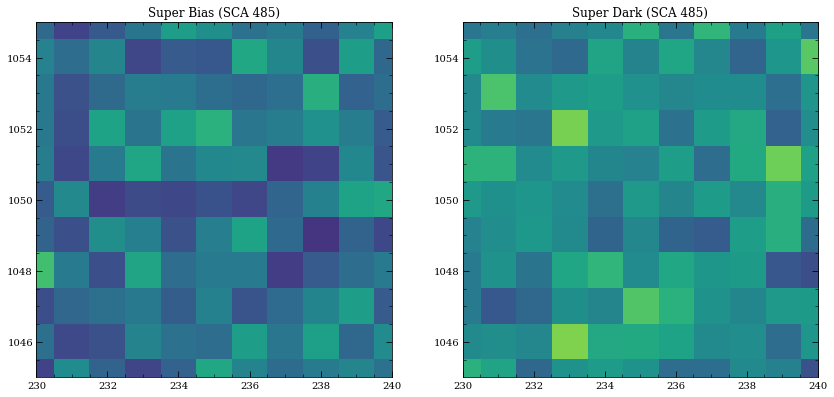

In [43]:
fig, axes = plt.subplots(1,2,figsize=(14,8))

titles = ['Super Bias (SCA {})'.format(scaid), 'Super Dark (SCA {})'.format(scaid)]
for i, im in enumerate([super_bias, super_dark]):

    mn = np.median(im)
    std = robust.medabsdev(im)

    vmin = mn - 3*std
    vmax = mn + 3*std
    ax = axes[i]
    ax.imshow(im, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    
    ax.set_xlim([230,240])
    ax.set_ylim([1045,1055])

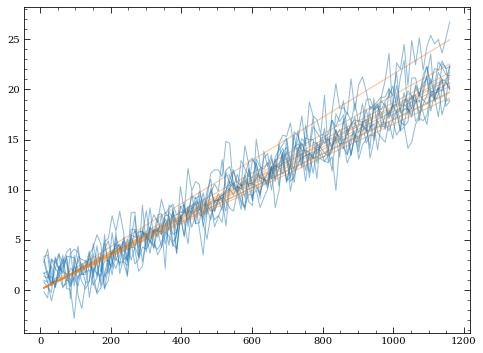

In [74]:
xvals = np.random.randint(5,2000, 10)
yvals = np.random.randint(5,2000, 10)

for i in range(len(xvals)):
    
    pix = data2[:,int(yvals[i]),int(xvals[i])]
#     pix = pix - np.median(pix)
    cf = jl_poly_fit(tarr,pix, deg=1)

    plt.plot(tarr, pix, color='C0', lw=1, alpha=0.5)
    plt.plot(tarr, jl_poly(tarr,cf), color='C1', lw=1, alpha=0.5)

In [90]:
cfarr = jl_poly_fit(tarr[:15], data2[:15,:,:], deg=1)

In [94]:
data2 -= cfarr[0]

In [95]:


# Get median of all pixels at each time step
ramp_avg = np.median(data2.reshape([nz,-1]), axis=1)
# Remove offset
cf = jl_poly_fit(tarr, ramp_avg)
# ramp_avg -= cf[0]

# del data2

1166.4249533983634 0.01872237275437635 0.01900762935236517


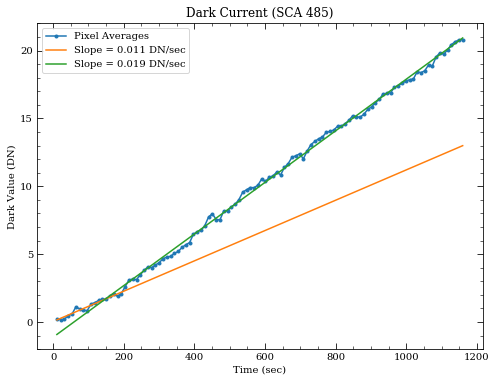

In [96]:

# print(np.median(super_bias0), np.median(super_dark2))

# Check linearity over flux range
plt.plot(tarr, ramp_avg, marker='.', label='Pixel Averages')

ind = tarr<200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

ind = tarr>200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))


plt.xlabel('Time (sec)')
plt.ylabel('Dark Value (DN)')
plt.title('Dark Current (SCA {})'.format(scaid))
plt.legend()
# plt.plot(tarr, ramp_avg2, marker='.', ls='none', color='C1')
# bias, slope2 = jl_poly_fit(tarr, ramp_avg2)
# plt.plot(tarr, tarr*slope2, color='C1')

print(np.median(super_bias), np.median(super_dark), cf[1])

1166.4249533983634 0.01872237275437635 0.019006404623438004


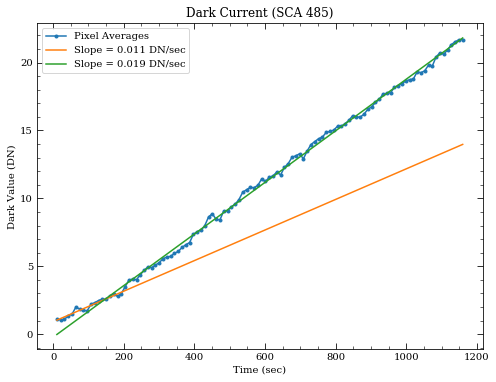

In [82]:

# print(np.median(super_bias0), np.median(super_dark2))

# Check linearity over flux range
plt.plot(tarr, ramp_avg, marker='.', label='Pixel Averages')

ind = tarr<200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))

ind = tarr>200
cf = jl_poly_fit(tarr[ind], ramp_avg[ind], deg=1)
plt.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.3f} DN/sec'.format(cf[1]))


plt.xlabel('Time (sec)')
plt.ylabel('Dark Value (DN)')
plt.title('Dark Current (SCA {})'.format(scaid))
plt.legend()
# plt.plot(tarr, ramp_avg2, marker='.', ls='none', color='C1')
# bias, slope2 = jl_poly_fit(tarr, ramp_avg2)
# plt.plot(tarr, tarr*slope2, color='C1')

print(np.median(super_bias), np.median(super_dark), cf[1])

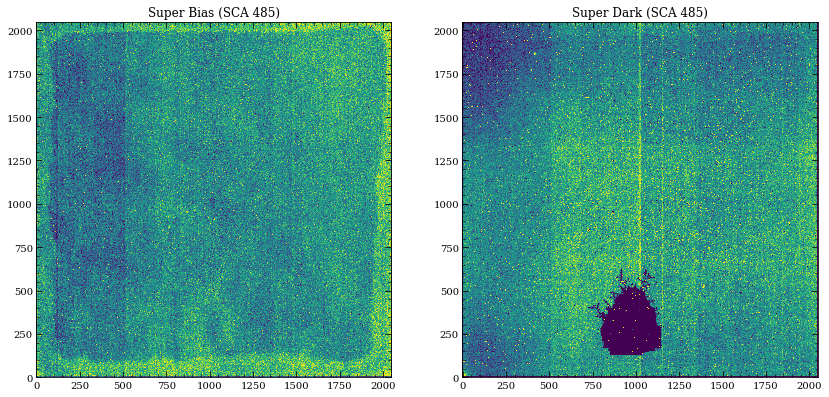

In [11]:
fig, axes = plt.subplots(1,2,figsize=(14,8))

titles = ['Super Bias (SCA {})'.format(scaid), 'Super Dark (SCA {})'.format(scaid)]
for i, im in enumerate([super_bias, super_dark]):

    mn = np.median(im)
    std = robust.medabsdev(im)

    vmin = mn - 3*std
    vmax = mn + 3*std
    ax = axes[i]
    ax.imshow(im, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

In [12]:
# Histogram of Dark Slope
im = super_dark
#im = dark_all[0]
binsize = 0.0001
bins = np.arange(im.min(), im.max() + binsize, binsize)
igroups, vgroups, center_vals = nrc_utils.hist_indices(im, bins=bins, return_more=True)

# Choose only those pixels at the peak binsize
nvals = np.array([len(ig) for ig in igroups])
ind_nvals_max = np.where(nvals==nvals.max())[0][0]
ig_good = igroups[ind_nvals_max]

Dark Current = 0.0188 DN/sec


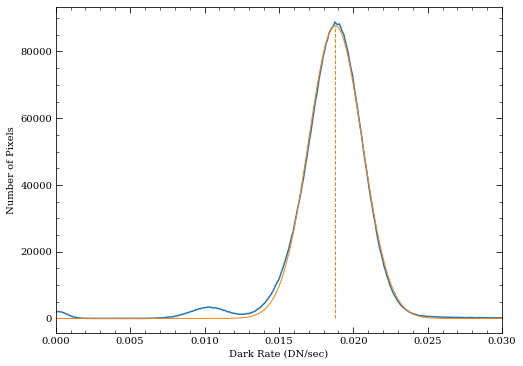

In [13]:
bg_max_dn = center_vals[ind_nvals_max]
#bg_max_e = bg_max_dn * gain
bg_max_npix = nvals[ind_nvals_max]

from astropy.modeling import models, fitting
mn_init, std_init = np.median(im), robust.std(im)
g_init = models.Gaussian1D(amplitude=nvals.max(), mean=mn_init, stddev=std_init)

fit_g = fitting.LevMarLSQFitter()
x, y = center_vals, nvals
ind_fit = (x>mn_init-10*std_init) & (x<mn_init+10*std_init)
g_res = fit_g(g_init, x[ind_fit], y[ind_fit])

bg_max_dn = g_res.mean.value
bg_max_npix = g_res.amplitude.value

plt.plot(center_vals, nvals)
plt.plot(2*[bg_max_dn], [0,bg_max_npix], ls='--', lw=1, color='C1')
plt.plot(x, g_res(x), label='Gaussian', lw=1, color='C1')
plt.xlabel('Dark Rate (DN/sec)')
plt.ylabel('Number of Pixels')

plt.xlim([0,0.03])

print('Dark Current = {:.4f} DN/sec'.format(bg_max_dn))

# IPC

In [14]:
# Get IPC & PPC values
# Subtract a blurred dark image to remove local variations
imdark = super_dark.copy()
imdark -= ndimage.median_filter(imdark, 7)

In [15]:
k_ipc, k_ppc = get_ipc_kernel(imdark, tarr.max(), bg_remove=False, calc_ppc=True)
print(k_ipc)
print(k_ppc)

[[3.84134703e-04 5.96783176e-03 3.84134703e-04]
 [5.96783176e-03 9.76128673e-01 5.96783176e-03]
 [3.84134703e-04 5.96783176e-03 3.84134703e-04]]
[[0.        0.        0.       ]
 [0.        0.9987649 0.0012351]
 [0.        0.        0.       ]]


In [16]:
# Flux-dependent values
vals1 = np.arange(5000,21000,1000)
vals2 = vals1+1000

vals = []
alpha_arr = []
ppc_arr = []
for v1 in vals1:
    k1, k2 = get_ipc_kernel(imdark, tarr.max(), boxsize=5, bg_remove=False, hotcut=[v1,v1+1000], calc_ppc=True)
    
    if k1 is not None:
        vals.append(v1+500)
        alpha_arr.append(k1[0,1])
        ppc_arr.append(k2[1,2])
        
vals = np.array(vals)
alpha_arr = np.array(alpha_arr)
ppc_arr = np.array(ppc_arr)

IPC = 0.597% +/- 0.018%
PPC = 0.124% +/- 0.010%


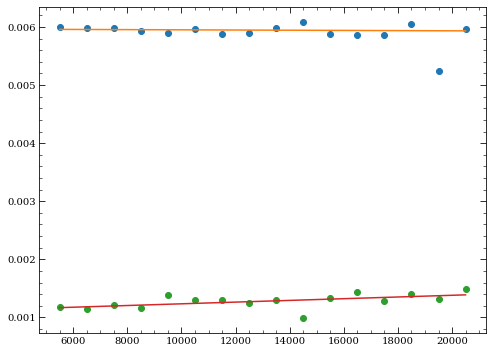

In [17]:
plt.plot(vals, alpha_arr, marker='o', ls='none')
cf1 = jl_poly_fit(vals, alpha_arr, robust_fit=True)
plt.plot(vals, jl_poly(vals, cf1))

plt.plot(vals, ppc_arr, marker='o', ls='none')
cf2 = jl_poly_fit(vals, ppc_arr, robust_fit=True)
plt.plot(vals, jl_poly(vals, cf2))

alpha = k_ipc[0,1]
_alpha = np.std(alpha_arr - jl_poly(vals, cf1))

ppc = k_ppc[1,2]
_ppc = np.std(ppc_arr - jl_poly(vals, cf2))


print('IPC = {:.3f}% +/- {:.3f}%'.format(alpha*100, _alpha*100))
print('PPC = {:.3f}% +/- {:.3f}%'.format(ppc*100, _ppc*100))

In [18]:
super_dark_deconv = ipc_deconvolve(super_dark, k_ipc)
super_bias_deconv = ipc_deconvolve(super_bias, k_ipc)

super_dark_deconv = ppc_deconvolve(super_dark_deconv, k_ppc)
super_bias_deconv = ppc_deconvolve(super_bias_deconv, k_ppc)

TypeError: 'float' object cannot be interpreted as an integer

In [18]:
nchans=nchan
same_scan_direction = reverse_scan_direction = False
for im in [super_dark_deconv, super_bias_deconv]:
    # Image cube shape
    sh = im.shape
    ndim = len(sh)
    if ndim==2:
        ny, nx = sh
        nz = 1
    else:
        nz, ny, nx = sh
    im = im.reshape([nz,ny,nchan,-1])

    for ch in np.arange(nchan):
        sub = im[:,:,ch,:]
        if same_scan_direction:
            flip = True if reverse_scan_direction else False
        elif np.mod(ch,2)==0:
            flip = True if reverse_scan_direction else False
        else:
            flip = False if reverse_scan_direction else True

        if flip: 
            sub = sub[:,:,::-1]

        sub = ipc_deconvolve(sub, k_ppc, kfft=kfft)
        if flip: 
            sub = sub[:,:,::-1]
        im[:,:,ch,:] = sub

    im = im.reshape(sh)

In [19]:
# Get IPC values
# Subtract a blurred dark image to remove local variations
imdark = super_dark_deconv.copy()
imdark -= ndimage.median_filter(imdark, 7)

k1, k2 = get_ipc_kernel(imdark, tarr.max(), bg_remove=False, calc_ppc=True)
print(k1)
print(k2)

[[2.80228587e-05 7.47127211e-05 2.80228587e-05]
 [7.47127211e-05 9.99701149e-01 7.47127211e-05]
 [2.80228587e-05 7.47127211e-05 2.80228587e-05]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.99917319e-01 8.26806276e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


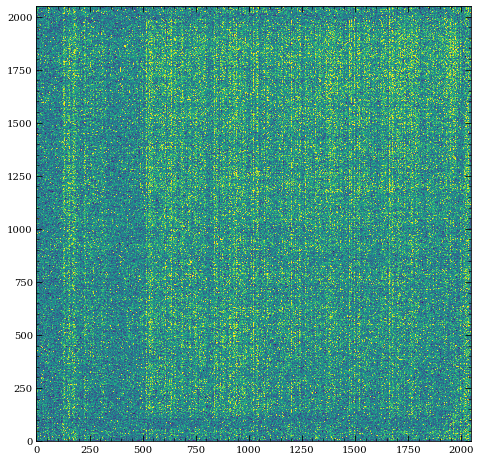

In [67]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

im = _super_bias
mn = np.median(im)
std = robust.medabsdev(im)

vmin = mn - 3*std
vmax = mn + 3*std
ax.imshow(im, vmin=vmin, vmax=vmax)

In [41]:
diff = super_bias0 - super_bias

(-1, 1)

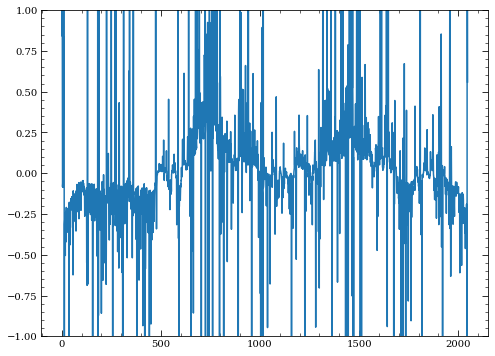

In [62]:
# plt.plot(diff[:,1020])
plt.plot(diff[:,1020] / super_bias[:,1020])
plt.ylim([-1,1])
# plt.plot(super_bias0[:,1020])